Calibration
======

Here's what we're doing: using the maximum bin (or bins) within the peaks to d the calibration, checking what the previous calibration parameters are, and going from there. So, it's going to be a lot of shit.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import pyne
import sap
pyne.__version__, sap.__version__

('0.5.0', '2017-04-18')

In [2]:
run289 = pyne.EVTData('../data_np/run289')
run289.load_data()
run289.__dict__

reading from ../data_np/run289...


{'adc': <pyne.detector.DetectorArray at 0x7fe8d44c1898>,
 'buffer': pyne.buffer.EVT_Buffer,
 'buffer_file': None,
 'data_file': '../data_np/run289',
 'f': <pyne.file.File at 0x7fe8d44c1860>,
 'run_information': {'end_time': '2017-03-02T09:46:49',
  'run_number': 289,
  'run_time': 74793,
  'start_time': '2017-03-01T13:00:16',
  'title': 'calibration run post experiment 40V mixed alpha Am-241 Gd-148'}}

In [3]:
run289.adc[16].__dict__

{'adc': [],
 'binned': False,
 'bins': array([   0,    1,    2, ..., 4094, 4095, 4096]),
 'channels': 4096,
 'counts': array([0, 0, 0, ..., 0, 0, 0]),
 'energies': array([  -85.61467588,   -83.96130235,   -82.30792881, ...,  6681.6432165 ,
         6683.29659004,  6684.94996358]),
 'name': 'adc_16'}

Current Calibration Values
-------------------------------

adc_16:  1.6534 -85.6147
adc_17:  1.7327 -165.1249
adc_18:  1.5791 -123.6602
adc_19:  1.6824 -172.4145
adc_20:  1.6923 -194.5315
adc_21:  1.7636 -235.3622
adc_22:  1.7946 -202.5862
adc_23:  1.8526 -203.9285
adc_24:  1.8725 -269.1918
adc_25:  1.8166 -252.4622
adc_26:  1.8509 -243.0183
adc_27:  1.8291 -272.2456
adc_28:  1.8161 -235.0588
adc_29:  1.7601 -172.8124
adc_30:  1.8246 -235.2623
adc_31:  1.6412 -110.0024


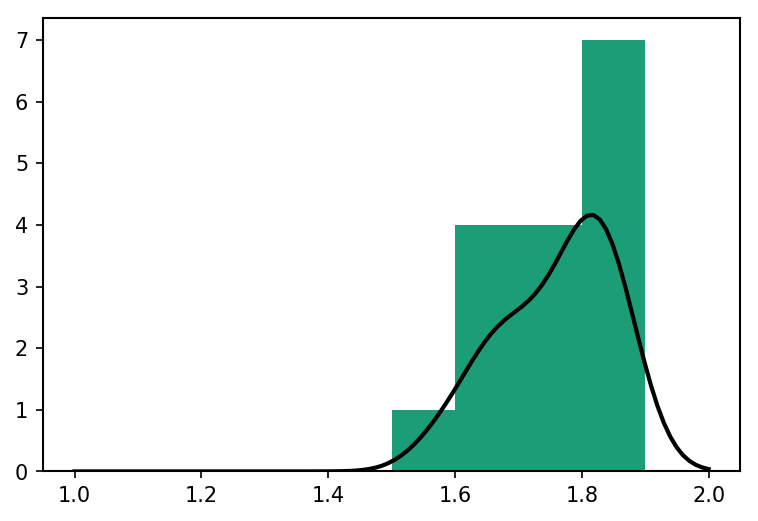

In [4]:
good_adcs = run289.adc[16:]

slopes = []
for adc in good_adcs:
    intercept = adc.energies[0]
    slope = adc.energies[1] - adc.energies[0]
    print('{}: {:7.4f} {:7.4f}'.format(adc.name, slope, intercept))
    slopes.append(slope)

plt.hist(slopes, bins=np.linspace(1, 2, 11))

from scipy.stats import gaussian_kde

density = gaussian_kde(slopes)
xs = np.linspace(1, 2, 100)
# density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs, density(xs), 'k-')
plt.show()

Using Peak Counts
--------------------

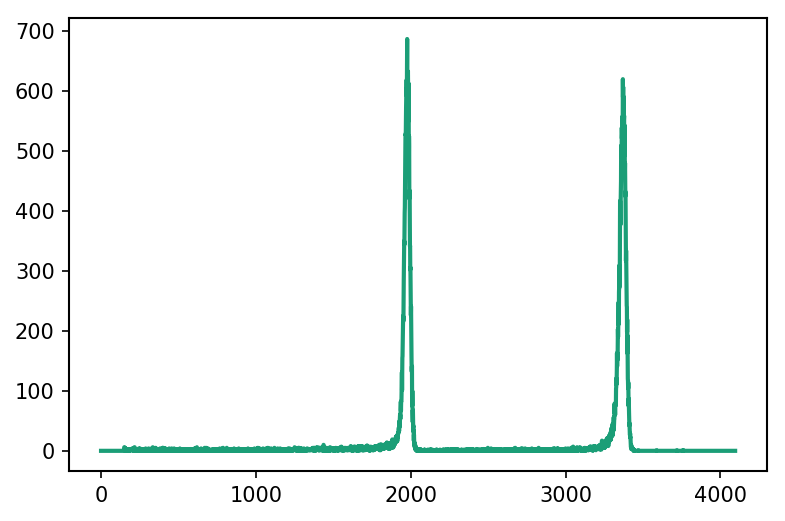

In [5]:
plt.plot(good_adcs[0].bins[:-1], good_adcs[0].counts)

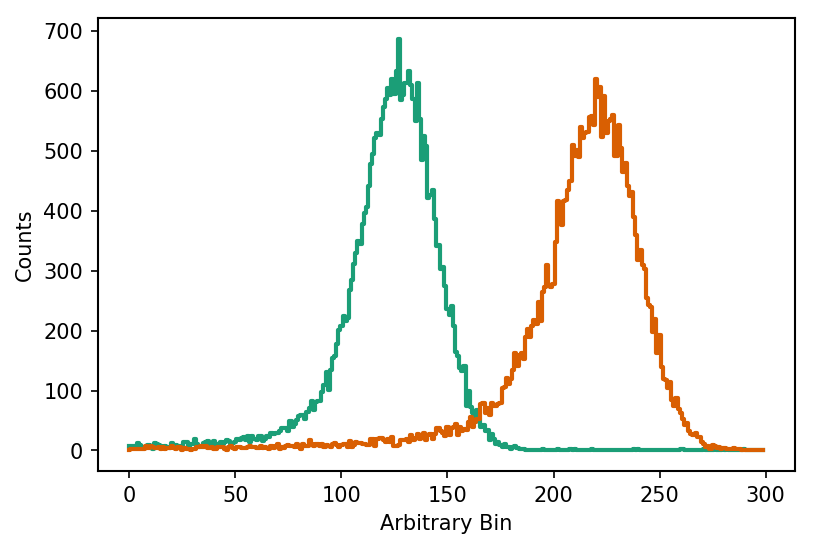

In [6]:
peak_0 = good_adcs[0].counts[1850:2150]
peak_1 = good_adcs[0].counts[3150:3450]

peak_bins = np.arange(300)
plt.plot(peak_bins, peak_0, linestyle='steps-mid')
plt.plot(peak_bins, peak_1, linestyle='steps-mid')
plt.xlabel('Arbitrary Bin')
plt.ylabel('Counts')

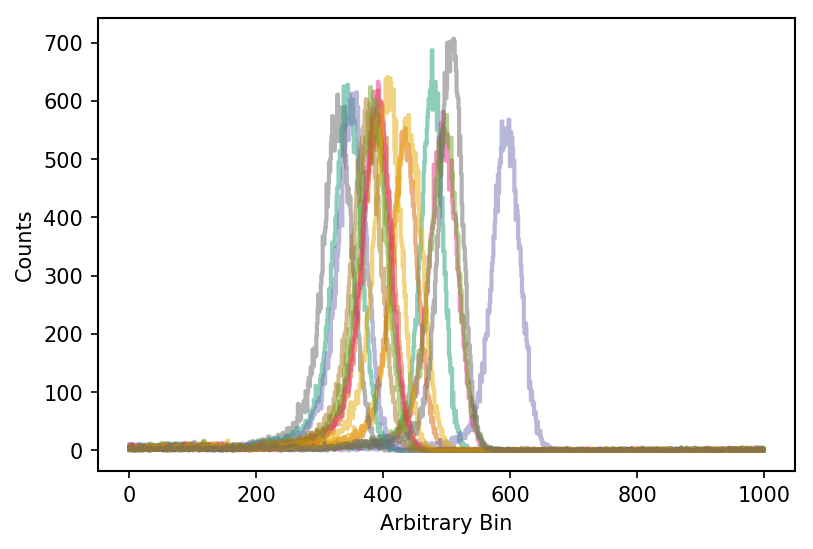

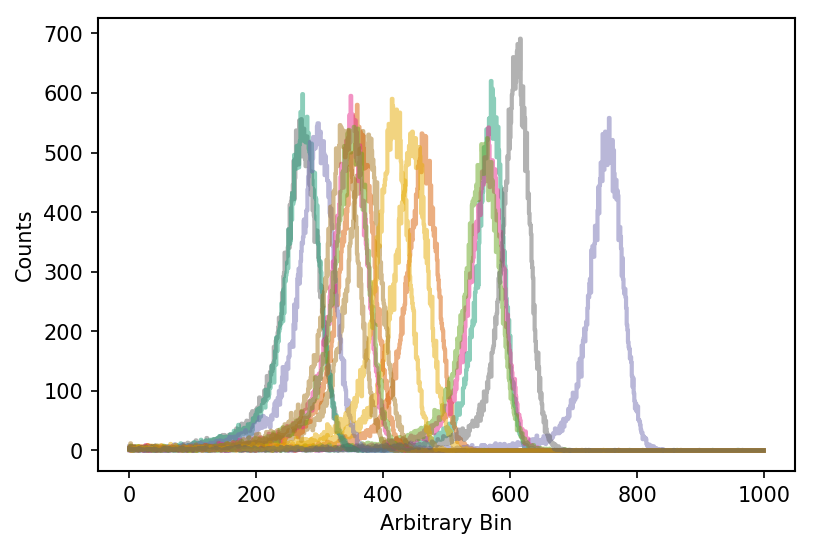

In [7]:
for adc in good_adcs:
    peak_0 = adc.counts[1500:2500]
    peak_bins = np.arange(1000)
    plt.plot(peak_bins, peak_0, linestyle='steps-mid', alpha=0.5)
    plt.xlabel('Arbitrary Bin')
    plt.ylabel('Counts')
plt.show()

for adc in good_adcs:
    peak_1 = adc.counts[2800:3800]
    peak_bins = np.arange(1000)
    plt.plot(peak_bins, peak_1, linestyle='steps-mid', alpha=0.5)
    plt.xlabel('Arbitrary Bin')
    plt.ylabel('Counts')
plt.show()

In [8]:
peak_0 = good_adcs[0].counts[1850:2150]
peak_1 = good_adcs[0].counts[3150:3450]

for i, peak in enumerate((peak_0, peak_1)):
    max_counts = peak.max()
    lower_bound = max_counts - np.sqrt(max_counts)
    location = peak > lower_bound
    print('Peak {}: {} bins'.format(i, location.sum()))
    print(peak[location])

Peak 0: 1 bins
[687]
Peak 1: 2 bins
[620 607]


In [9]:
peak_0_center = peak_0.argmax() + 1850
peak_0_center, peak_0.argmax()
peak_0[peak_0.argmax()] == good_adcs[0].counts[peak_0_center]

True

In [10]:
heights = peak_1[peak_1 > peak_1.max() - np.sqrt(peak_1.max())]  # heights
locations = np.where(peak_1 > peak_1.max() - np.sqrt(peak_1.max()))[0]  # bins
peak_1_heights = np.where(peak_1 >= (peak_1.max() - np.sqrt(peak_1.max())))
peak_1_center = locations + 3150
peak_1[locations] == good_adcs[0].counts[peak_1_center]

array([ True,  True], dtype=bool)

In [11]:
peak_0_center, peak_1_center.mean()

(1977, 3371.0)

Using Fit
----------

In [12]:
from scipy.optimize import curve_fit
from scipy.signal import find_peaks_cwt

In [13]:
peaks = find_peaks_cwt(good_adcs[0].counts, np.arange(175, 250, 25))
peaks, good_adcs[0].counts[peaks]

([294, 1973, 3364], array([  1, 593, 521]))

In [27]:
heights = good_adcs[0].counts[peaks]
good_peaks = np.where(heights > 50)[0]
new_peaks = np.take(peaks, good_peaks)

for i, peak in enumerate(new_peaks):
    p0 = [600, peak, 50]
    pars, _ = curve_fit(sap.functions.gaussian, good_adcs[0].bins[:-1], good_adcs[0].counts, p0=p0)
    print('Peak {}: {}'.format(i, pars[1]))

Peak 0: 1976.7491133217168
Peak 1: 3369.580162453649


Comparison
------------

Bin locations for the two peaks are within 1.5 bins (for this ADC), which should be less than 5 keV difference for the calibration. For our 16 ADCs, we need to repeat the process above and compare the peak locations and the resulting calibration parameters.

In [15]:
def automatic(adc):
    peaks = find_peaks_cwt(adc.counts, np.arange(175, 250, 25))
    heights = adc.counts[peaks]
    good_peaks = np.where(heights > 50)[0]
    new_peaks = np.take(peaks, good_peaks)
    
    final_bins = []
    for peak in new_peaks:
        p0 = [600, peak, 50]
        pars, _ = curve_fit(_single_gaus, adc.bins[:-1], adc.counts, p0=p0)
        final_bins.append(pars[1])
    return final_bins

def manual(adc):
    peak_0_offset = 1500
    peak_1_offset = 2800
    peak_0 = manual_single_peak(adc, peak_0_offset)
    peak_1 = manual_single_peak(adc, peak_1_offset)
    return peak_0, peak_1
    

def manual_single_peak(adc, offset, bins=1000):
    peak = adc.counts[offset:offset + bins]
    peak_bins = np.arange(bins)
    max_counts = peak.max()
    lower_bound = max_counts - np.sqrt(max_counts)
    location = np.where(peak > lower_bound)[0]
    return location + offset

In [16]:
peak_0_auto = []
peak_0_manu = []
peak_1_auto = []
peak_1_manu = []

for adc in good_adcs:
    print(adc.name)
    manual_peaks = manual(adc)
    auto_peaks = automatic(adc)
    for peak, auto in zip(manual_peaks, auto_peaks):
        print('{:10.5f} -- {:10.5f}'.format(peak.mean(), auto))
    print(manual_peaks, auto_peaks, ' ', sep='\n')
    peak_0_auto.append(auto_peaks[0])
    peak_1_auto.append(auto_peaks[1])
    peak_0_manu.append(manual_peaks[0].mean())
    peak_1_manu.append(manual_peaks[1].mean())

adc_16
1977.00000 -- 1976.74911
3371.00000 -- 3369.58016
(array([1977]), array([3370, 3372]))
[1976.7491133217168, 3369.5801624536489]
 
adc_17
1931.66667 -- 1932.18511
3264.33333 -- 3261.28223
(array([1929, 1930, 1931, 1932, 1933, 1935]), array([3261, 3265, 3267]))
[1932.1851075822124, 3261.282227483121]
 
adc_18
2095.28571 -- 2093.76397
3553.00000 -- 3552.06874
(array([2087, 2093, 2095, 2096, 2097, 2098, 2101]), array([3550, 3556]))
[2093.763974929841, 3552.0687356532253]
 
adc_19
1992.50000 -- 1994.28581
3366.00000 -- 3363.11979
(array([1991, 1994]), array([3366]))
[1994.2858142306986, 3363.1197906969765]
 
adc_20
1997.00000 -- 1995.66640
3359.00000 -- 3356.47745
(array([1995, 1996, 1997, 2000]), array([3355, 3356, 3361, 3364]))
[1995.6663954146443, 3356.4774466761578]
 
adc_21
1936.50000 -- 1938.12635
3246.28571 -- 3243.91479
(array([1934, 1935, 1937, 1940]), array([3242, 3243, 3245, 3246, 3248, 3249, 3251]))
[1938.1263525604897, 3243.9147913878314]
 
adc_22
1889.00000 -- 1886.3912

In [17]:
test_adc = good_adcs[12]
test_adc.name

'adc_28'

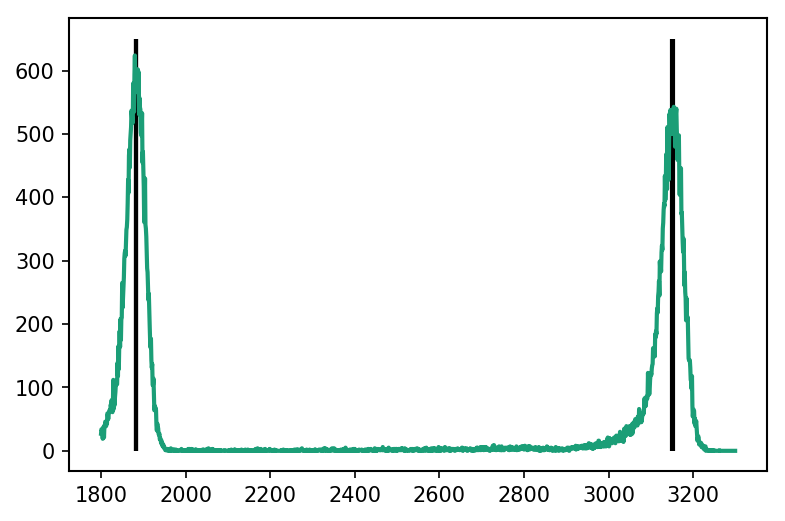

In [18]:
plt.plot(test_adc.bins[1800:3300], test_adc.counts[1800:3300])
plt.vlines([1883.333, 1881.929, 3152.3, 3149.969], 0, 650, 'k')

In [19]:
zipped = zip(peak_0_auto, peak_0_manu, peak_1_auto, peak_1_manu)
for a, b, c, d in zipped:
    print('{:7.2f} {:7.2f}  |  {:7.2f} {:7.2f}'.format(a, b, c, d))

1976.75 1977.00  |  3369.58 3371.00
1932.19 1931.67  |  3261.28 3264.33
2093.76 2095.29  |  3552.07 3553.00
1994.29 1992.50  |  3363.12 3366.00
1995.67 1997.00  |  3356.48 3359.00
1938.13 1936.50  |  3243.91 3246.29
1886.39 1889.00  |  3169.63 3174.29
1828.00 1833.00  |  3071.02 3069.25
1843.47 1843.00  |  3073.31 3073.00
1891.02 1893.00  |  3158.73 3158.00
1850.85 1853.60  |  3095.06 3097.00
1888.91 1889.50  |  3147.96 3149.00
1881.93 1883.33  |  3149.97 3152.30
1906.47 1910.00  |  3214.87 3218.67
1873.28 1873.33  |  3135.42 3137.86
2006.29 2008.00  |  3409.46 3413.00


In [20]:
import statsmodels.api as sm

energies = [3182.69, 5485.56]

auto_pars = []
man_pars = []
results_a = []
results_m = []

zipped = zip(peak_0_auto, peak_0_manu, peak_1_auto, peak_1_manu)
for p0a, p0m, p1a, p1m in zipped:
    centers_a = sm.add_constant([p0a, p1a])
    result_a = sm.OLS(energies, centers_a).fit()
    centers_m = sm.add_constant([p0m, p1m])
    result_m = sm.OLS(energies, centers_m).fit()
    print(result_a.params, result_m.params)
    auto_pars.append(result_a.params)
    man_pars.append(result_m.params)
    results_a.append(result_a)
    results_m.append(result_m)

[-85.61467588   1.65337354] [-83.28847202   1.65198709]
[-165.12488281    1.73265743] [-155.26188844    1.72801651]
[-123.66020526    1.5791418 ] [-127.40352117    1.57978146]
[-172.41445531    1.68235888] [-158.02239534    1.67664361]
[-194.53145021    1.69227756] [-193.83818649    1.69080029]
[-235.36219039    1.76358584] [-222.07133337    1.75820363]
[-202.58619115    1.79457803] [-201.86596421    1.79171835]
[-203.92852976    1.85263511] [-231.79793529    1.86278665]
[-269.19184071    1.87249524] [-267.87049593    1.87225203]
[-252.46215019    1.81656205] [-263.42297233    1.82045059]
[-243.01832529    1.85087884] [-250.31613801    1.85207496]
[-272.24560733    1.82906015] [-272.07210004    1.82840016]
[-235.05878032    1.81608761] [-235.10807718    1.81476004]
[-172.81237896    1.76006292] [-178.35052471    1.75970708]
[-235.26228091    1.82457894] [-228.90502165    1.82113613]
[-110.00235255    1.6411879 ] [-108.52918861    1.63905338]


In [21]:
slopes = np.array([r.params[1] for r in results_a])
slopes.mean(), slopes.std(ddof=0)

(1.7600951142838248, 0.084980102950716938)

Refitting
----------

Use the results to refit each spectrum... The peak centers will be at the same place, since we used their energy for calibration

In [22]:
auto_E = []
man_E = []

bins = sm.add_constant(np.arange(4096))
for res_a, res_m, adc in zip(results_a, results_m, good_adcs):
    auto_E.append(res_a.predict(bins))
    man_E.append(res_m.predict(bins))

In [23]:
run270 = pyne.EVTData('../data_np/run270')
run270.load_data()
run270.__dict__

reading from ../data_np/run270...


{'adc': <pyne.detector.DetectorArray at 0x7fe898170748>,
 'buffer': pyne.buffer.EVT_Buffer,
 'buffer_file': None,
 'data_file': '../data_np/run270',
 'f': <pyne.file.File at 0x7fe8981703c8>,
 'run_information': {'end_time': '2017-02-28T08:04:24',
  'run_number': 270,
  'run_time': 906,
  'start_time': '2017-02-28T07:49:18',
  'title': 'Al27_pa_E=1.369MeV_final_TuningSheet_191'}}

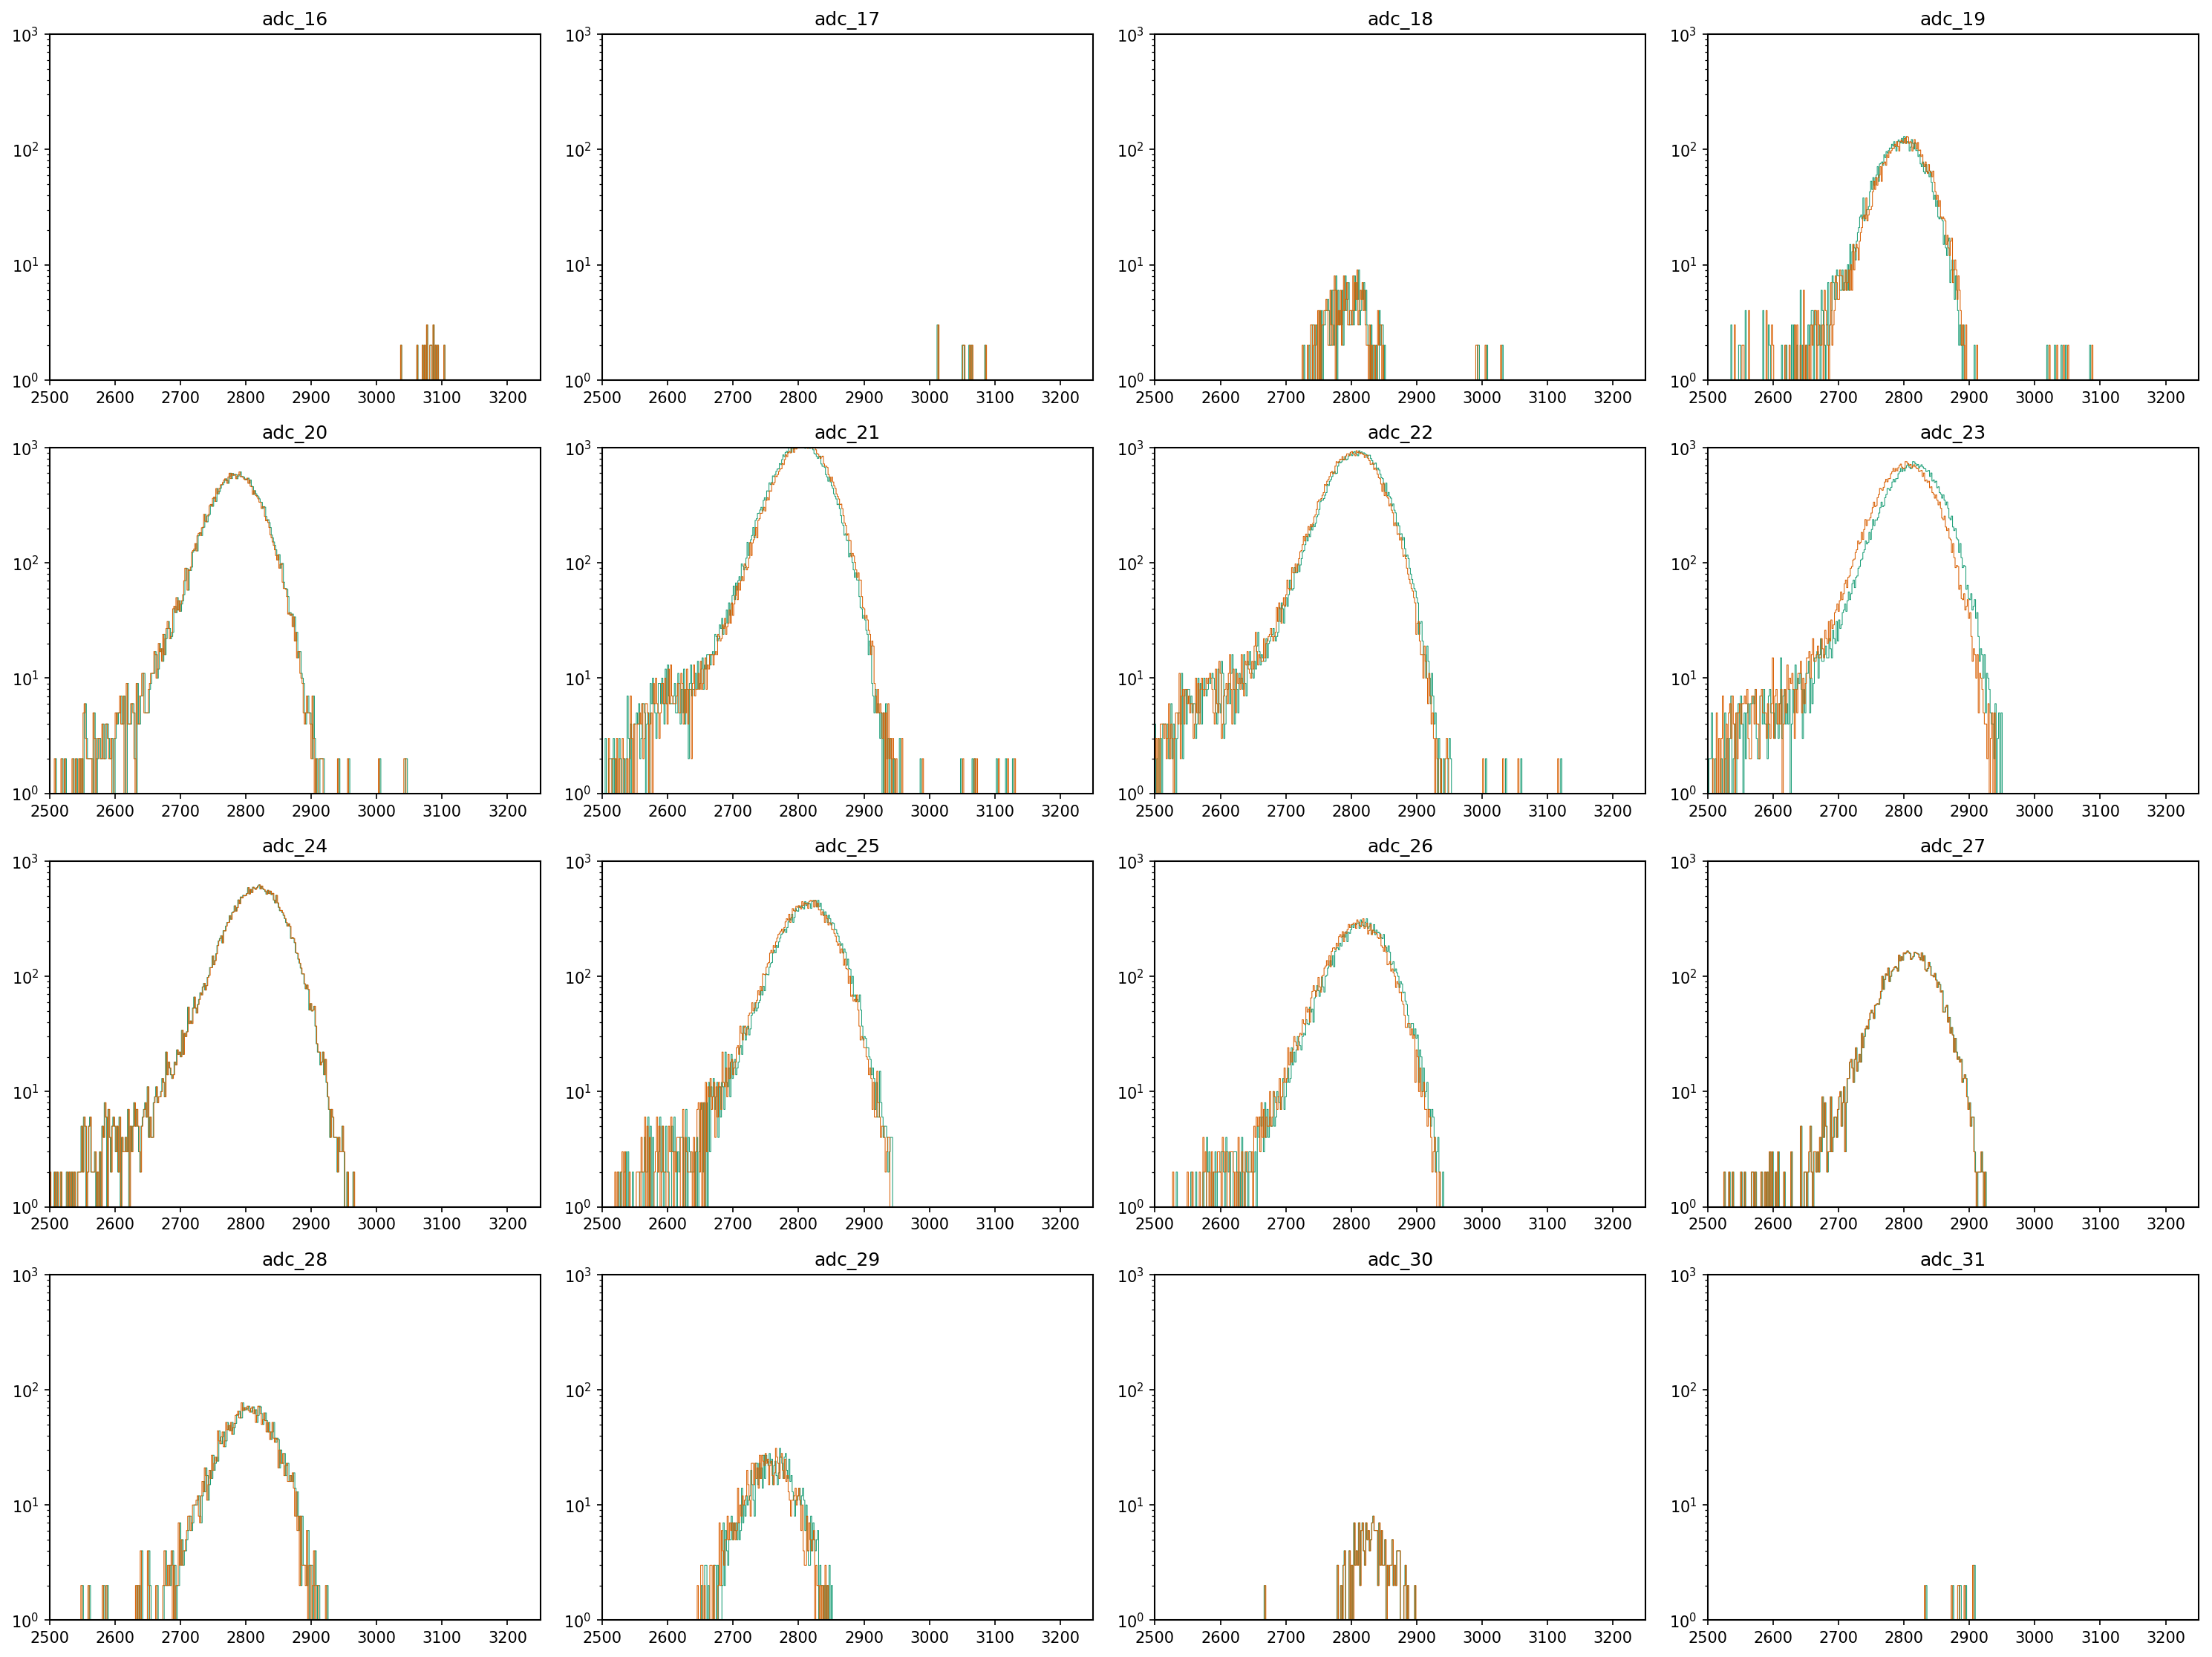

In [24]:
figsize = (20, 15)
xlim = (2500, 3250)
ylim = (1, 1000)

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=figsize)
axis = axes.ravel()
for ax, adc, e_auto, e_man in zip(axis, run270.adc[16:], auto_E, man_E):
    ax.semilogy(e_auto, adc.counts, nonposy='clip', linestyle='steps-mid', lw=0.5)
    ax.semilogy(e_man, adc.counts, nonposy='clip', linestyle='steps-mid', lw=0.5)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    ax.set_title(adc.name)
fig.tight_layout()

Below, `xxx-yyy` describes the methods used for each stage of the check. `xxx` determines which energy calibration scheme was used, and `yyy` determines which final experimental spectrum peak detection method was used. Since this is experimental data, only the detector strips near the center have good statistics, so some peak detections there may be off. Look at strips 20-27 (center 8 strips).

In [25]:
for adc, e_auto, e_man in zip(run270.adc[16:], auto_E, man_E):
    print(adc.name)
    # automatic
    loc = np.argmax(adc.counts)
    p0 = [adc.counts.max(), loc, 50]
    pars_a, _ = curve_fit(_single_gaus, e_auto, adc.counts, p0=p0)
    pars_m, _ = curve_fit(_single_gaus, e_man, adc.counts, p0=p0)
    print('auto-auto', pars_a[1], 'man-auto', pars_m[1])
    
    # manual
    peak = adc.counts.max()
    lower_bound = peak - np.sqrt(peak)
    location = np.where(adc.counts > lower_bound)[0]
    final_loc = int(location.mean())
    print('auto-man ', e_auto[final_loc], 'man-man ', e_man[final_loc], '\n')

adc_16
auto-auto 1886.85833939 man-auto 1887.61149788
auto-man  3077.28890294 man-man  3076.9628264 

adc_17
auto-auto 1834.00000522 man-auto 1834.00000355
auto-man  3054.15262215 man-man  3055.39278389 

adc_18
auto-auto 2795.00735299 man-auto 2792.44655201
auto-man  2800.91040225 man-man  2798.35173951 

adc_19
auto-auto 2797.32076734 man-auto 2801.62408206
auto-man  2800.31369139 man-man  2804.60686567 

adc_20
auto-auto 2786.46055463 man-auto 2784.55158413
auto-man  2782.18477078 man-man  2780.2795301 

adc_21
auto-auto 2803.25893484 man-auto 2807.27636613
auto-man  2801.5326251 man-man  2805.55532094 

adc_22
auto-auto 2808.6012782 man-auto 2804.52314548
auto-man  2808.71573888 man-man  2804.63742803 

adc_23
auto-auto 2815.21219623 man-auto 2803.88624305
auto-man  2814.01405838 man-man  2802.68152275 

adc_24
auto-auto 2817.37394007 man-auto 2818.29440142
auto-man  2820.42530075 man-man  2821.34535772 

adc_25
auto-auto 2817.41096359 man-auto 2813.02153245
auto-man  2821.16083238

Check ADC 23, since it shows a big shift in the peak location depending on which calibration you use.

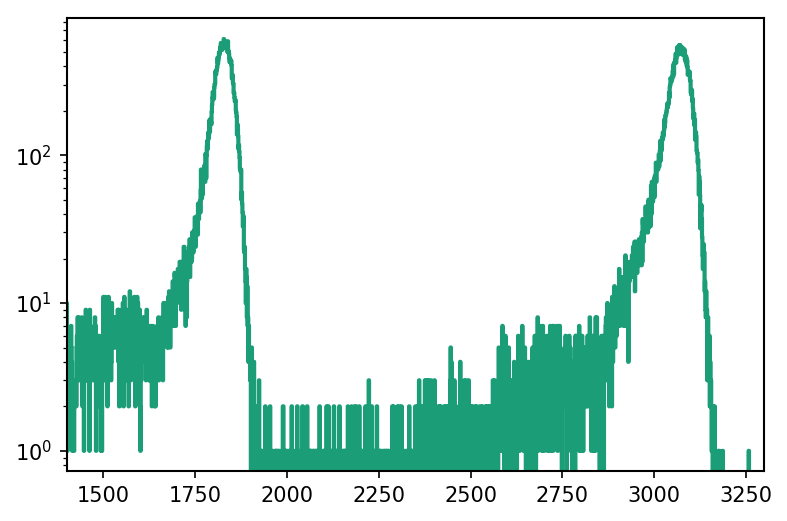

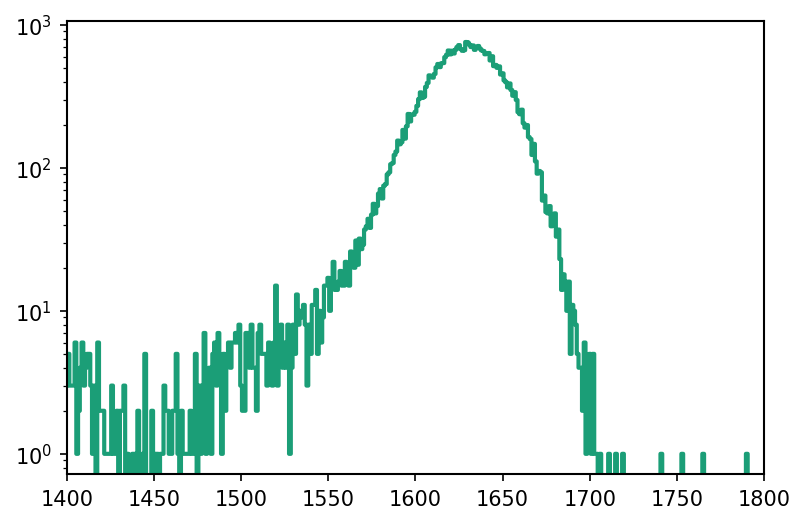

In [26]:
check_adc_cal = run289.adc[23]
check_adc_run = run270.adc[23]

plt.semilogy(check_adc_cal.bins[:-1], check_adc_cal.counts, linestyle='steps-mid', nonposy='clip')
plt.xlim(1400, 3300)
plt.show()
plt.semilogy(check_adc_run.bins[:-1], check_adc_run.counts, linestyle='steps-mid', nonposy='clip')
plt.xlim(1400, 1800)
plt.show()

Energy Resolution
--------------------

Using the calibration data, we need to find the energy resolution (taken as the FWHM of the lower calibration peak) for our strips. Here, our central energy can be taken as the calibration energy. We will use the actual data instead of the approximation $FWHM = 2.35\sigma$.

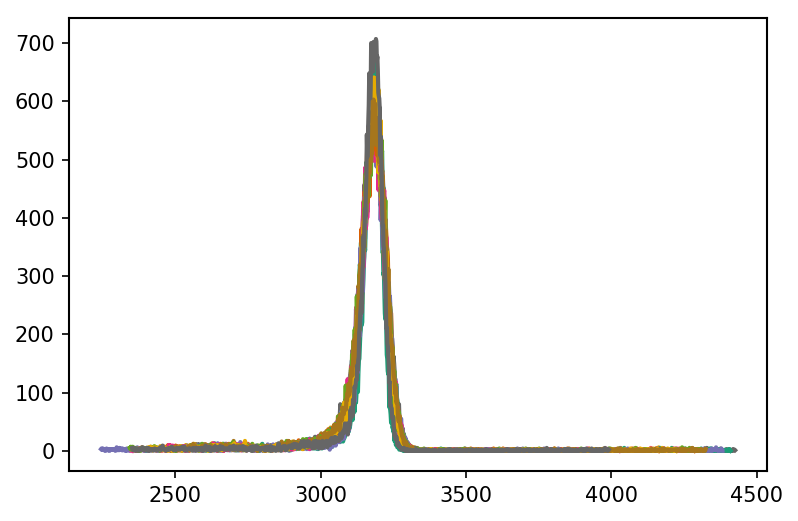

In [51]:
for good_adc in run289.adc[16:]:
    low_counts = good_adc.counts[1500:2500]
    low_energy = good_adc.energies[1500:2500]
    plt.plot(low_energy, low_counts)

In [75]:
e_peak = 3182.69

for adc in run289.adc[16:]:
    print(adc.name)
    counts = adc.counts[:2500]
    half_max = counts.max() / 2
    print(half_max)
    
    for i, value in enumerate(counts):
        if value > half_max:
            left = i
            break
    # right
    for i, value in enumerate(counts[::-1]):
        if value > half_max:
            right = 2500 - i
            break
    widths = [adc.energies[right] - adc.energies[left],
              adc.energies[right - 1] - adc.energies[left - 1],
              adc.energies[right + 1] - adc.energies[left - 1],
              adc.energies[right - 1] - adc.energies[left + 1],
              adc.energies[right + 1] - adc.energies[left + 1]]
    widths = np.array(widths)
    print(widths.mean(), widths.std(ddof=1))
    print('resolution: {} +/- {}%\n'.format(widths.mean() * 100 / e_peak, widths.std(ddof=1) * 100 / e_peak))

adc_16
343.5
61.1748209182 2.33822328158
resolution: 1.922110570562407 +/- 0.07346688749378369%

adc_17
276.5
84.9002140704 2.45034763647
resolution: 2.6675615303546873 +/- 0.07698983050392587%

adc_18
284.0
75.7988062421 2.23324374582
resolution: 2.3815956389751207 +/- 0.0701684344318123%

adc_19
290.5
82.4355852792 2.37921474947
resolution: 2.5901229865039217 +/- 0.07475483787200253%

adc_20
288.0
86.3061553558 2.39324187099
resolution: 2.7117361526178105 +/- 0.07519556950214794%

adc_21
288.0
91.7064636501 2.49408701252
resolution: 2.881413635951634 +/- 0.07836412005326178%

adc_22
293.5
95.1126354539 2.53791658513
resolution: 2.98843542581663 +/- 0.07974124357482719%

adc_23
305.5
90.779120208 2.62002169344
resolution: 2.852276539906992 +/- 0.08232098298724529%

adc_24
314.0
95.4972570996 2.64810815999
resolution: 3.0005202234469595 +/- 0.08320345870928457%

adc_25
309.0
96.2777884609 2.56900668296
resolution: 3.0250444894392214 +/- 0.08071809327824131%

adc_26
307.5
92.5439422188 